# Imports

In [2]:
!cat /proc/meminfo | grep Mem

MemTotal:       775391696 kB
MemFree:        508339212 kB
MemAvailable:   737862636 kB


In [3]:
import multiprocessing
multiprocessing.cpu_count()

64

In [4]:
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sns
import sys
import os
import pickle
import dill
import warnings
import json
from tqdm import tqdm

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.base import ClassifierMixin, BaseEstimator

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [7]:
from IPython.display import clear_output

In [8]:
main_dir = '/sise/home/tommarz/hate_speech_detection/'
detection_dir = os.path.join(main_dir, 'detection')
experiments_dir = os.path.join(detection_dir, 'experiments')
aggregative_methods_dir = os.path.join(detection_dir, 'aggregative_methods')
models_dir = os.path.join(aggregative_methods_dir, 'models')
sna_dir = os.path.join(detection_dir, 'sna')
os.chdir(main_dir)
os.getcwd()

'/sise/home/tommarz/hate_speech_detection'

In [9]:
from config.data_config import path_confs
from config.detection_config import user_level_execution_config, user_level_conf, post_level_execution_config

In [10]:
def write_results_latex(df, name):
    with open(os.path.join(method_output_path, f'{method_name}_{name}_results_latex.txt'), 'w') as f:
        res = ' & '.join([f'${m:.3f} \pm {s:.3f}$' for m, s in df.values.reshape(-1, 2)]) + '\\\\'
        f.write(res)

def get_best_results_from_gs(gs):
    train_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[
                                     gs.best_index_, [c for c in gs.cv_results_ if
                                                      'mean_train' in c or 'std_train' in c]].values.reshape(-1, 2),
                                 columns=['mean', 'std'], index=scoring_names)
    test_results = pd.DataFrame(pd.DataFrame.from_dict(gs.cv_results_).loc[gs.best_index_, [c for c in gs.cv_results_ if
                                                                                            'mean_test' in c or 'std_test' in c]].values.reshape(
        -1, 2), columns=['mean', 'std'], index=scoring_names)
    # best_hyper_params = pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    return {'train': train_results, 'test': test_results}

def get_best_results_from_cv_results(cv_results):
    train_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_train' in c or 'std_train' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    test_results =  pd.DataFrame(pd.DataFrame.from_dict(cv_results).loc[:, [c for c in cv_results if  'mean_test' in c or 'std_test' in c]].values.reshape(-1,2), columns=['mean', 'std'], index=scoring_names)
    return {'train': train_results, 'test': test_results}

def write_best_results_and_params_from_gs(gs):
    results_dict = get_best_results_from_gs(gs)
    pd.Series(gs.best_estimator_.get_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_hyperparams.csv'))
    pd.Series(gs.best_estimator_.get_learned_params()).rename('value').to_csv(os.path.join(method_output_path, 'best_params.csv'))

    for name, df in results_dict.items():
        write_results_latex(df, name=name)
        df.to_csv(os.path.join(method_output_path, f'best_results_{name}.csv'))
        
    return results_dict

In [11]:
scoring_list = [precision_score, recall_score, f1_score, roc_auc_score]
scoring_names = ['_'.join(f.__name__.split('_')[:-1]) for f in scoring_list]
scoring_dict = {n:f for n, f in zip(scoring_names, scoring_list)}
scoring_dict

{'precision': <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'recall': <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'f1': <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'roc_auc': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

# Plot Mean Uttrance Score per User for each Dataset

# Choose Dataset

In [12]:
dataset = 'echo_2'

In [13]:
path_confs['parler']

{'reposts': '/sise/Yalla_work/data/parler/echos_edge_dict.p',
 'posts': '/sise/home/tommarz/hate_speech_detection/detection/outputs/parler/BertFineTuning/user_level/all_users_tweets.parquet',
 'predictions': '/sise/home/tommarz/hate_speech_detection/detection/outputs/parler/BertFineTuning/user_level/split_by_posts/no_text/',
 'posts_with_predictions': '/sise/home/tommarz/hate_speech_detection/detection/outputs/parler/BertFineTuning/user_level/split_by_posts/with_text/',
 'doc_vectors': '/sise/home/tommarz/Hateful-users-detection/Dataset/ParlerData/Doc2Vec100.p',
 'raw_network': '/sise/home/tommarz/hate_speech_detection/data/networks_data/parler/raw_network.p',
 'largest_cc_network': '/sise/home/tommarz/hate_speech_detection/data/networks_data/parler/largest_cc.p'}

In [14]:
dataset_path_conf = path_confs[dataset]
network_output_dir = "/sise/home/tommarz/hate_speech_detection/data/networks_data"
raw_graphs_dict_path = os.path.join(network_output_dir, "raw_graphs_dict.p")
network_dataset_output_dir = os.path.join(network_output_dir, dataset)
raw_network_path  = os.path.join(network_dataset_output_dir, "raw_network.p")
raw_network_edgelist_path  = os.path.join(network_dataset_output_dir, "raw_network.txt")
largest_cc_path  = os.path.join(network_dataset_output_dir, "largest_cc.p")
largest_cc_edgelist_path  = os.path.join(network_dataset_output_dir, "largest_cc.txt")

# Load Dataset (Graph)

In [15]:
with open(largest_cc_path, 'rb') as f:
    g = pickle.load(f)
# g.reverse_edges()
g.summary()

'IGRAPH DNW- 3746 20728 -- echo_2\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [16]:
labeled_nodes = g.vs.select(lambda v: v['label'] != -1)
len(labeled_nodes)

532

In [17]:
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label')
y

4779468079            1
740475620560277504    0
1580455592            0
2486965772            1
726798707597910016    1
                     ..
414953065             0
145783458             0
2243867573            0
2507835944            0
112712567             0
Name: label, Length: 532, dtype: int64

In [18]:
(np.array(g.vs.degree())==0).sum()

0

In [19]:
def expect_precision(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    # idxs = np.where(y_prob < thres)[0]
    # fn = y_prob[idxs].sum()
    return tp/(tp+fp)

def expect_f1(y_true, y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_true, y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_true, y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres #, f1s 

# Load Posts and Predictions

In [209]:
dataset_path_conf['posts_with_predictions']

'/sise/home/tommarz/hate_speech_detection/detection/outputs/parler/BertFineTuning/user_level/split_by_posts/with_text/'

In [175]:
posts_with_predictions_df = pd.read_parquet(dataset_path_conf['posts_with_predictions'])

In [176]:
predictions_output_path = os.path.join(post_level_execution_config["evaluation"]["output_path"], 'predictions.tsv')
predictions_df = pd.read_csv(predictions_output_path, sep='\t')
y_true = predictions_df['y_true']
y_prob = predictions_df['y_score']
y_pred = predictions_df['y_pred']

In [177]:
# def optimal_threshold(y_true, y_prob):
y_prob = np.sort(y_prob)[::-1]
precisions = [expect_precision(y_true, y_prob, p) for p in y_prob]
thres = y_prob[np.argmax(precisions)]
thres

0.9950218

In [178]:
post_threshold = optimal_threshold(y_true, y_prob)
# post_threshold=0.9
# post_threshold=thres
post_threshold

0.4196834

# Define Ego Network

In [179]:
def get_ego_subgraph(g, vertices, order_k = 1):
    ego_network = g.neighborhood(vertices=vertices, order=order_k, mode='out')
    set_of_tuples = set(tuple(inner_list) for inner_list in ego_network)
    flattened_set = list({element for tupl in set_of_tuples for element in tupl})
    ego_subgraph = g.subgraph(flattened_set)
    return ego_subgraph

In [180]:
ego_g = get_ego_subgraph(g, labeled_nodes)
ego_g.summary()

'IGRAPH DNW- 10163 1559834 -- parler\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [181]:
labeled_nodes_ego = ego_g.vs.select(lambda v: v['label']!=-1)
v = labeled_nodes_ego[0]

# Define Seed (Random State)

In [182]:
seed = 42

In [183]:
results_str = ''

# Define Centrality Measures

# Define Post Threshold for HS Count

In [184]:
post_th = 0.5 #np.percentile(preds, q=99)

In [185]:
def get_hs_count(hate_probas, post_threshold):
    return (hate_probas >= post_threshold).sum()

# Aggregative Methods

In [186]:
results_dict = {}

## Fixed Threshold

In [187]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions')
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label')

In [188]:
hs_count_transformer = FunctionTransformer(lambda X, post_threshold=0.5: np.array([get_hs_count(np.array(prob_list), post_threshold) for prob_list in X]).reshape(-1, 1), validate=False)

In [189]:
all_probas_concat = np.concatenate(labeled_nodes['predictions'])

In [190]:
mean_probas = np.array(list(map(np.mean, labeled_nodes['predictions'])))
post_thresholds = np.percentile(mean_probas, q=[1,5,10,25,50,75,90,95,99])

In [191]:
post_thresholds = np.sort(np.concatenate((np.quantile(all_probas_concat, np.linspace(0, 1, 11)), [0.5])))
post_thresholds

array([1.75024150e-04, 1.28004490e-03, 2.59004789e-03, 5.24983183e-03,
       1.07542798e-02, 1.93013735e-02, 4.44684476e-02, 1.07036181e-01,
       2.69669175e-01, 4.99265194e-01, 5.00000000e-01, 9.93205428e-01])

### Without ML

In [192]:
class FixedThresholdClassifer(ClassifierMixin, BaseEstimator):
    def __init__(self, post_th):
        self.post_th = post_th
    def fit(self, X, y=None):
        self.is_fitted_ = True
        return self
    def predict(self, X):
        return (X>=self.post_th).astype(int)
    def predict_proba(self, X):
        preds = self.predict(X)
        return np.column_stack((1-preds, preds))
    def decision_function(self, X):
        return self.predict(X)

In [193]:
hs_count = hs_count_transformer.fit_transform(X)
# hs_count

In [194]:
scores_dict = {post_th: {k: v(y, hs_count >= post_th) for k,v in scoring_dict.items()} for post_th in [1,3,10,50,100]}
scores_df = pd.DataFrame.from_dict(scores_dict)
scores_df.T

,precision,recall,f1,roc_auc
1,0.308176,0.882883,0.456876,0.607602
3,0.340782,0.824324,0.482213,0.643573
10,0.347727,0.689189,0.462236,0.626840
50,0.457447,0.387387,0.419512,0.616304
100,0.607477,0.292793,0.395137,0.614530


### With ML (LR)

In [195]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    hs_count_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f3a3e21c160>)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [215]:
param_grid = {
    # 'functiontransformer__kw_args': [{'post_threshold': p} for p in post_thresholds],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [216]:
fixed_gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [217]:
fixed_gs.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function <lambda> at 0x7f3a3e21c160>)),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=100,
             param_grid={'logisticregression__C': array([1.        , 0.46415888, 0.21544347, 0.1       , 0.04641589,
       0.02154435, 0.01      , 0.00464159, 0.00215443, 0.001     ]),
                         'logisticregression__class_weight': ['balanced']},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'], verbose=1)

In [218]:
results_dict_fixed = get_best_results_from_gs(fixed_gs)
for name, df in results_dict_fixed.items():
    print(name)
    display(df)

train


,mean,std
precision,0.474508,0.013188
recall,0.376112,0.01762
f1,0.419429,0.013879
roc_auc,0.692869,0.006527


test


,mean,std
precision,0.470127,0.050063
recall,0.369192,0.040207
f1,0.411634,0.035108
roc_auc,0.693366,0.02601


In [219]:
results_dict['fixed'] = results_dict_fixed['test']

In [221]:
fixed_overleaf = '& Fixed-Threshold '
for m, s in results_dict_fixed['test'].astype(float).values:
    fixed_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(fixed_overleaf + '\\\\')

& Fixed-Threshold & $0.470 \pm 0.050$& $0.369 \pm 0.040$& $0.412 \pm 0.035$& $0.693 \pm 0.026$\\


In [222]:
best_pipe = fixed_gs.best_estimator_
best_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f3a3e21c160>)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [223]:
with open(os.path.join(models_dir, dataset, 'fixed_method.dill'), 'wb') as f:
    dill.dump(best_pipe, f)

In [224]:
fixed_model = best_pipe.steps[-1][1]
fixed_model

LogisticRegression(class_weight='balanced', random_state=42)

In [225]:
fixed_model.coef_[0][0], int(np.ceil(fixed_model.coef_[0][0]))

(1.014113379137751, 2)

In [227]:
fixed_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
fixed_preds_df

,pred,label
Mcmlv2,1,1
Jazzlm,0,1
Djanides,0,0
Jsnwaugh,0,0
PJW,1,0
...,...,...
KennyEee,1,1
Canuck987,0,0
LKDOG,0,0
CBean,1,1


In [229]:
fixed_preds_df['pred'].mean() == fixed_preds_df['label'].mean()

False

## Relational Threshold

In [230]:
# agg_func = np.mean
def get_relational_feats(g, vs=None, pipe=None, agg_func=np.mean, weighted=False):
    if vs is None:
        vs = g.vs.select(lambda v: v['label'] != -1)
    res = []
    for v in vs:
        self_preds = v['predictions']
        followers = g.vs[g.neighbors(v, mode='in')]
        followees = g.vs[g.neighbors(v, mode='out')]
        followers_preds = np.array(followers['predictions'], dtype='O')
        followees_preds = np.array(followees['predictions'], dtype='O')

        self_agg = agg_func(self_preds)
        followers_agg = np.array([agg_func(p) for p in followers_preds])
        followees_agg = np.array([agg_func(p) for p in followees_preds])

        followers_weights = np.array(g.es.select(_target=v.index)['weight']) if weighted else np.ones_like(g.es.select(_target=v.index), dtype=int)
        followees_weights = np.array(g.es.select(_source=v.index)['weight']) if weighted else np.ones_like(g.es.select(_source=v.index), dtype=int)

        followers_agg_weighted = (followers_agg * followers_weights).sum()/followers_weights.sum() if len(followers)>0 else 0
        followees_agg_weighted = (followees_agg * followees_weights).sum()/followees_weights.sum() if len(followees)>0 else 0

        # mean_followers_agg_weighted = followers_agg_weighted.mean() if followers_agg_weighted.size>0 else 0
        # mean_followees_agg_weighted = followees_agg_weighted.mean() if followees_agg_weighted.size>0 else 0
        res.append([self_agg, followers_agg_weighted, followees_agg_weighted])
    df = pd.DataFrame(res, columns=['self', 'followers_agg', 'followees_agg'], index=vs['name'])
    return df

In [231]:
weighted = True
agg_func = lambda p, th=0.5: get_hs_count(p, th)
relational_transformer = FunctionTransformer(get_relational_feats, kw_args={'agg_func': agg_func, 'weighted': weighted, 'vs':g.vs})

In [232]:
X = relational_transformer.fit_transform(g)
X


KeyboardInterrupt



### Train

In [ ]:
labeled_X = X.loc[y.index]

In [ ]:
pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=seed))
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='mean'), LogisticRegression(random_state=seed))
# pipe = make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression(random_state=seed))
pipe.set_output(transform='pandas')
pipe

In [ ]:
thresholds, is_weighted = np.meshgrid(post_thresholds, [True], indexing='xy')

In [ ]:
param_grid = {
    # 'functiontransformer__kw_args': [{'agg_func': lambda p, th: get_hs_count(p, th), 'weighted': weighted} for th, weighted in np.column_stack((thresholds.flatten(), is_weighted.flatten()))],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [ ]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [ ]:
gs.fit(labeled_X, y)

### Results

In [ ]:
results_dict_relat = get_best_results_from_gs(gs)
for name, df in results_dict_relat.items():
    print(name)
    display(df)

In [ ]:
results_dict['relational'] = results_dict_relat['test']

In [ ]:
overleaf = '& Relational Aggregation '
for m, s in results_dict_relat['test'].astype(float).values:
    overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(overleaf + '\\\\')

In [ ]:
best_pipe = gs.best_estimator_
model = best_pipe.steps[-1][1]
best_pipe

In [ ]:
with open(os.path.join(models_dir, dataset, 'relational_method.dill'), 'wb') as f:
    dill.dump(best_pipe, f)

### Params

In [ ]:
np.round(model.coef_[0], 3)

In [ ]:
preds = best_pipe.predict(X)
# {k: v(y, preds) for k,v in scoring_dict.items()}

In [ ]:
X_with_preds = X.join(pd.Series(preds, index=X.index, name='pred')).join(y)
X_with_preds

In [ ]:
labeled_X_with_preds = X_with_preds.query('`label`==`pred`')
labeled_X_with_preds

In [ ]:
tp_username = '2486965772'

In [ ]:
labeled_X_with_preds.loc[tp_username]

In [ ]:
labeled_X_with_preds.get('2875882289')

In [ ]:
[(k, labeled_X_with_preds.loc[k][['pred', 'label']].values) for k in ['395289872',
 '2875882289',
 '2801839926',
 '3352764254',
 '271380614',
 '346244155',
 '35888463',
 '730692228729950209'] if k in labeled_X_with_preds.index]

In [ ]:
user_posts = posts_with_predictions_df.query('`user_id`==@tp_username').sort_values(by=['predictions'])
user_posts

In [ ]:
user_posts

## Distributional (Bins)

In [233]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions')
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label')

In [254]:
n_bins = 10
density = True
bins_range = (0, 1)
hs_bins_count_transformer = FunctionTransformer(
    lambda X, n_bins, bins_range=(0,1), density=True: pd.DataFrame(np.array([np.histogram(prob_list, bins=n_bins, range=bins_range, density=density)[0] for prob_list in X])/n_bins, columns=range(1, n_bins+1), index=X.index), validate=False, kw_args={'n_bins' :n_bins, 'density': density, 'bins_range': bins_range})

In [276]:
np.bincount(prob_list)

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [277]:
hs_bins_count_transformer.fit_transform(X) #.sum(axis=1)-1 < 1e-4).all()

,1,2,3,4,5,6,7,8,9,10
Mcmlv2,0.693034,0.071940,0.053711,0.047201,0.050456,0.037435,0.016927,0.012695,0.010742,0.005859
Jazzlm,0.809859,0.063380,0.024648,0.031690,0.056338,0.007042,0.003521,0.000000,0.003521,0.000000
Djanides,0.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Jsnwaugh,0.906250,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000
PJW,0.815898,0.062586,0.037917,0.029237,0.029694,0.016446,0.005025,0.000914,0.001827,0.000457
...,...,...,...,...,...,...,...,...,...,...
KennyEee,0.592159,0.085540,0.056517,0.054990,0.072301,0.062118,0.025458,0.018330,0.020876,0.011711
Canuck987,0.708543,0.085427,0.045226,0.025126,0.030151,0.050251,0.030151,0.010050,0.010050,0.005025
LKDOG,0.585859,0.060606,0.030303,0.090909,0.070707,0.050505,0.040404,0.010101,0.020202,0.040404
CBean,0.194313,0.033175,0.047393,0.052133,0.127962,0.127962,0.042654,0.123223,0.118483,0.132701


In [265]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    hs_bins_count_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f3a3e2fa940>,
                                     kw_args={'bins_range': (0, 1),
                                              'density': True, 'n_bins': 10})),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [266]:
n_bins = 10
density = True
bins_range = (0, 1)
param_grid = {
    'functiontransformer__kw_args': [{'n_bins': n_bins, 'density': density, 'bins_range': bins_range}],
    'logisticregression__C': np.logspace(0, -3, 10),
    'logisticregression__class_weight': ['balanced']
}

In [267]:
bins_gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [268]:
bins_gs.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('functiontransformer',
                                        FunctionTransformer(func=<function <lambda> at 0x7f3a3e2fa940>,
                                                            kw_args={'bins_range': (0,
                                                                                    1),
                                                                     'density': True,
                                                                     'n_bins': 10})),
                                       ('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             n_jobs=100,
             param_grid={'functiontransformer__kw_args': [{'bins_range': (0, 1),
                                                           'density': True,
                                                           'n_bins': 10}],
                         'logisticregression__C': array([1.        , 0.46415888, 0.21544347, 0.1       , 0.04641589,
       0.02154435, 0.01      , 0.00464159, 0.00215443, 0.001     ]),
                         'logisticregression__class_weight': ['balanced']},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'], verbose=1)

In [269]:
results_dict_bins = get_best_results_from_gs(bins_gs)
for name, df in results_dict_bins.items():
    print(name)
    display(df)

train


,mean,std
precision,0.292928,0.010723
recall,0.500019,0.020086
f1,0.369384,0.013432
roc_auc,0.587515,0.007052


test


,mean,std
precision,0.28356,0.037305
recall,0.500202,0.075125
f1,0.361593,0.049425
roc_auc,0.575082,0.023595


In [270]:
bins_overleaf = '& Distributional (Bins) '
for m, s in results_dict_bins['test'].astype(float).values:
    bins_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(bins_overleaf + '\\\\')

& Distributional (Bins) & $0.284 \pm 0.037$& $0.500 \pm 0.075$& $0.362 \pm 0.049$& $0.575 \pm 0.024$\\


In [271]:
results_dict['disributional_bins'] = results_dict_bins['test']

In [272]:
best_pipe = bins_gs.best_estimator_
best_pipe

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f3a3e2fa940>,
                                     kw_args={'bins_range': (0, 1),
                                              'density': True, 'n_bins': 10})),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0021544346900318843,
                                    class_weight='balanced',
                                    random_state=42))])

In [273]:
bins_model = best_pipe.steps[-1][1]
bins_model

LogisticRegression(C=0.0021544346900318843, class_weight='balanced',
                   random_state=42)

In [274]:
bins_model.coef_[0]

array([-0.04000593, -0.00789527,  0.0453939 ,  0.029387  ,  0.02675369,
        0.02454971,  0.02410251,  0.04575637,  0.01398772,  0.00630051])

In [275]:
bins_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
bins_preds_df

,pred,label
Mcmlv2,1,1
Jazzlm,0,1
Djanides,0,0
Jsnwaugh,0,0
PJW,0,0
...,...,...
KennyEee,1,1
Canuck987,1,0
LKDOG,1,0
CBean,1,1


## Distributional (Qunatiles)

In [279]:
X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions')
y = pd.Series(labeled_nodes['label'], index=labeled_nodes['name'], name='label')

In [280]:
# Sample data: a list of NumPy arrays with probabilities
probability_arrays = X  # Replace with your actual data
q = np.linspace(0, 1, 11)
# Define a function to calculate quantiles
def calculate_quantiles(data, q):
    return np.quantile(data, q)

# Define a function to calculate the mean probability in each quantile
def mean_probabilities_in_quantiles(data, q):
    quantiles = calculate_quantiles(data, q)
    mean_probs = []
    for i in range(len(quantiles) - 1):
        quantile_range = data[(data >= quantiles[i]) & (data < quantiles[i + 1])]
        mean_probs.append(np.mean(quantile_range) if len(quantile_range) > 0 else 0)
    return np.array(mean_probs)

# Vectorize the mean probabilities function
vectorized_mean_probs = np.vectorize(mean_probabilities_in_quantiles, signature='(n)->(m)')

# Use FunctionTransformer to apply the vectorized function
mean_quantile_hs_proba_transformer = FunctionTransformer(lambda x, q: np.array([mean_probabilities_in_quantiles(arr, q) for arr in x]), kw_args={'q': q})

In [281]:
# Transform the list of probability arrays into a single NumPy array
quantile_means_array = mean_quantile_hs_proba_transformer.fit_transform(probability_arrays)

# Print the result
print("Mean probabilities in each quantile for all arrays:")
quantile_means_array

Mean probabilities in each quantile for all arrays:


array([[9.13670093e-04, 2.07616760e-03, 3.94817096e-03, ...,
        1.75955125e-01, 3.65882566e-01, 6.28333454e-01],
       [9.51245193e-04, 2.04961919e-03, 4.09420121e-03, ...,
        6.92235295e-02, 1.72515784e-01, 4.17284589e-01],
       [0.00000000e+00, 0.00000000e+00, 1.79384393e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.01790327e-03, 1.80667810e-03, 3.31156533e-03, ...,
        3.85511324e-01, 5.32268721e-01, 7.95089225e-01],
       [6.14371443e-03, 4.85170670e-02, 2.32404028e-01, ...,
        7.64521565e-01, 8.61743495e-01, 9.27095202e-01],
       [5.51261503e-04, 1.43516776e-03, 3.26776158e-03, ...,
        2.90968627e-01, 5.72458256e-01, 9.30216312e-01]])

In [ ]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    mean_quantile_hs_proba_transformer,
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

In [ ]:
q = np.linspace(0, 1, 11)

param_grid = {
    'functiontransformer__kw_args': [{'q': q}],
    'logisticregression__C': np.logspace(0, -5, 30),
    'logisticregression__class_weight': ['balanced']
}

In [ ]:
quantiles_gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [ ]:
quantiles_gs.fit(X, y)

In [ ]:
results_dict_quantiles = get_best_results_from_gs(quantiles_gs)
for name, df in results_dict_quantiles.items():
    print(name)
    display(df)

In [ ]:
results_dict['disributional_quantiles'] = results_dict_quantiles['test']

In [ ]:
quantiles_overleaf = '& Distributional (Quantiles) '
for m, s in results_dict_quantiles['test'].astype(float).values:
    quantiles_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(quantiles_overleaf + '\\\\')

In [ ]:
best_pipe = quantiles_gs.best_estimator_
best_pipe

In [ ]:
quantiles_model = best_pipe.steps[-1][1]
quantiles_model

In [ ]:
quantiles_model.coef_[0]

In [ ]:
quantiles_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
quantiles_preds_df

## Distributional (Bins + Quantiles)

In [278]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(
    make_column_transformer((mean_quantile_hs_proba_transformer, 0), (hs_bins_count_transformer, 0), sparse_threshold=0),
    StandardScaler(), 
    # SimpleImputer(strategy='mean'), 
    LogisticRegression(random_state=seed))
# pipe.set_output(transform='pandas')
pipe

NameError: name 'mean_quantile_hs_proba_transformer' is not defined

In [ ]:
X = pd.DataFrame(np.array(labeled_nodes['predictions']),  index=labeled_nodes['name'], columns=['post_predictions'])
# X = pd.Series(labeled_nodes['predictions'],  index=labeled_nodes['name'], name='post_predictions')
X

In [ ]:
pipe.fit(X, y)

In [ ]:
n_bins = 10
density = True
bins_range = (0, 1)

q = np.linspace(0, 1, 11)

param_grid = {
    'columntransformer__functiontransformer-1__kw_args': [{'q': q}],
    'columntransformer__functiontransformer-2__kw_args': [{'n_bins': n_bins, 'density': density, 'bins_range': bins_range}],
    'logisticregression__C': np.logspace(0, -5, 30),
    'logisticregression__class_weight': ['balanced']
}

In [ ]:
bins_quantiles_gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [ ]:
bins_quantiles_gs.fit(X, y)

In [ ]:
results_dict_bins_quantiles = get_best_results_from_gs(bins_quantiles_gs)
for name, df in results_dict_bins_quantiles.items():
    print(name)
    display(df)

In [ ]:
results_dict['disributional_bins_quantiles'] = results_dict_bins_quantiles['test']

In [ ]:
quantiles_overleaf = '& Distributional (Bins + Quantiles) '
for m, s in results_dict_bins_quantiles['test'].astype(float).values:
    quantiles_overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(quantiles_overleaf + '\\\\')

In [ ]:
best_pipe = bins_quantiles_gs.best_estimator_
best_pipe

In [ ]:
bins_quantiles_model = best_pipe.steps[-1][1]
bins_quantiles_model

In [ ]:
bins_quantiles_model.coef_[0]

In [ ]:
bins_quantiles_model_preds_df = pd.merge(pd.Series(best_pipe.predict(X), name='pred', index=X.index), y, left_index=True, right_index=True)
bins_quantiles_model_preds_df

## Multimodal (Relational + Bins + Quantiles)

In [ ]:
def get_relational_features(g, vs=None, pipe=None, features_attr_name='features', agg_func=np.mean, weighted=False):
    if vs is None:
        vs = g.vs.select(label_ne=-1)
    res = []
    for v in vs:
        self_feats = v[features_attr_name]
        followers = h.vs[ego_g.neighbors(v, mode='in')]
        followees = h.vs[ego_g.neighbors(v, mode='out')]
        followers_feats = np.array(followers[features_attr_name]) if len(followers)>0 else np.zeros_like(self_feats).reshape(-1, 1)
        followees_feats = np.array(followees[features_attr_name]) if len(followees)>0 else np.zeros_like(self_feats).reshape(-1, 1)

        followers_weights = np.array(h.es.select(_target=v.index)['weight']).reshape(-1, 1) if weighted and len(followers)>0 else np.ones_like(h.es.select(_target=v.index), dtype=int).reshape(-1,1) if len(followers)>0 else np.ones_like(self_feats) 
        followees_weights = np.array(h.es.select(_source=v.index)['weight']).reshape(-1, 1) if weighted and len(followees)>0 else np.ones_like(h.es.select(_source=v.index), dtype=int).reshape(-1,1)  if len(followees)>0 else np.ones_like(self_feats) 

        self_agg = self_feats #agg_func(self_feats)
        followers_agg = agg_func(followers_feats, followers_weights)
        followees_agg = agg_func(followees_feats, followees_weights)

        res.append(np.concatenate((self_agg, followers_agg, followees_agg)))

    return np.array(res)

In [ ]:
ct = make_column_transformer((mean_quantile_hs_proba_transformer, 0), (hs_bins_count_transformer, 0), sparse_threshold=0)
ct

In [ ]:
ego_g.summary()

In [ ]:
h = ego_g.copy()

In [ ]:
preds_df = pd.DataFrame(np.array(h.vs['predictions']), columns=['predictions'], index=h.vs['name'])
preds_df

In [ ]:
h.vs['features'] = ct.fit_transform(preds_df)

In [ ]:
h.vs['features'][1]

In [ ]:
h.summary()

In [ ]:
labeled_nodes = h.vs.select(label_ne=-1)
features_attr_name = 'features'
weighed = True
agg_func = lambda x, weights: ((x*weights)/weights.sum()).mean(axis=0)
v = labeled_nodes[0]
v['label']

In [ ]:
X_weighted = pd.DataFrame(get_relational_features(h, vs=h.vs, agg_func=agg_func, weighted=True), index=h.vs['name'])
X_weighted.shape

In [ ]:
X = pd.DataFrame(get_relational_features(h, vs=h.vs, agg_func=agg_func, weighted=False), index=h.vs['name'])
X.shape

### Train

In [ ]:
# pipe = make_pipeline(StandardScaler(), SimpleImputer(strategy='constant', fill_value=0), LogisticRegression(random_state=echo_seed))
pipe = make_pipeline(LogisticRegression(random_state=seed))
pipe.set_output(transform='pandas')
pipe

In [ ]:
param_grid = {
    'logisticregression__C': np.logspace(0, -5, 20),
    'logisticregression__class_weight': ['balanced']
}

In [ ]:
gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(shuffle=True, random_state=seed), scoring=scoring_names, return_train_score=True, refit='f1', n_jobs=100, verbose=1)

In [ ]:
X_labeled = X.loc[y.index]
X_labeled.shape

In [ ]:
gs.fit(X_labeled, y)

### Results

In [ ]:
results_dict_relat_bin_quantiles = get_best_results_from_gs(gs)
for name, df in results_dict_relat_bin_quantiles.items():
    print(name)
    display(df)

In [ ]:
results_dict['multimodal_relational_bins_quantiles'] = results_dict_relat_bin_quantiles['test']

In [ ]:
from sklearn.compose import make_column_transformer

In [ ]:
overleaf = '& Multimodal (Relational + Bins + Quantiles) '
for m, s in results_dict_relat_bin_quantiles['test'].astype(float).values:
    overleaf += (f'& ${m:.3f} \pm {s:.3f}$')
print(overleaf + '\\\\')

In [ ]:
best_pipe =  gs.best_estimator_

In [ ]:
model = best_pipe.steps[-1][1]
model

In [ ]:
np.round(model.coef_[0], 3)

In [ ]:
X_with_preds = pd.merge(pd.Series(best_pipe.predict(X_labeled), index=y.index, name='pred'), y, left_index=True, right_index=True)
X_with_preds

# Save Results to CSV

In [ ]:
# List to hold each dataframe with the added key index
frames = []

# Iterate over each key and dataframe in the dictionary
for key, df_tmp in results_dict.items():
    df = df_tmp.copy()
    # Add a new column with the key and set it as index
    df['Method'] = key
    # Set the 'Key' as part of the index
    df.set_index('Method', append=True, inplace=True)
    # Append the modified dataframe to the list
    frames.append(df)

# Concatenate all dataframes into a single dataframe
result = pd.concat(frames)

# Swap levels to make 'Key' the first level of the multi-index
result = result.swaplevel() #.sort_index()

result = result.rename_axis(['Method', 'Metric'])

# Display the resulting dataframe
result

In [ ]:
results_csv_name = f'{dataset}_results.csv'
results_csv_name

In [ ]:
result.to_csv(os.path.join(aggregative_methods_dir, results_csv_name))

# Compare Methods

In [ ]:
results_df = pd.concat([results_dict_fixed['test'], results_dict_relat['test'], test_scores_agg, results_dict_statistical['test']], axis=1, keys=['fixed', 'relat', 'dynamic', 'fine-tuned'])

# Plot

In [201]:
import matplotlib.patches as mpatches
import os

# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

In [202]:
df

,Dataset,Method,Accuracy,Precision,Recall,F1,ROC AUC,F1 Mean
0,Echo,DeGroot's Diffusion,0.780 ± 0.055,0.472 ± 0.389,0.255 ± 0.261,0.320 ± 0.310,0.610 ± 0.122,0.320
1,Echo,GCN,0.637 ± 0.171,0.443 ± 0.118,0.914 ± 0.096,0.585 ± 0.104,0.797 ± 0.102,0.585
2,Echo,GraphSAGE,0.831 ± 0.068,0.629 ± 0.124,0.950 ± 0.041,0.752 ± 0.088,0.944 ± 0.024,0.752
3,Echo,GAT,0.757 ± 0.064,0.548 ± 0.131,0.653 ± 0.241,0.574 ± 0.123,0.772 ± 0.091,0.574
4,Echo,AGNN,0.899 ± 0.026,0.759 ± 0.072,0.914 ± 0.054,0.826 ± 0.035,0.963 ± 0.032,0.826
5,Echo,Fixed-Threshold,0.812 ± 0.016,0.654 ± 0.063,0.627 ± 0.095,0.633 ± 0.040,0.836 ± 0.040,0.633
6,Echo,Relational Aggregation,0.908 ± 0.022,0.820 ± 0.060,0.834 ± 0.055,0.825 ± 0.042,0.956 ± 0.013,0.825
7,Echo,Distributional (bins),0.899 ± 0.023,0.772 ± 0.045,0.871 ± 0.058,0.817 ± 0.042,0.944 ± 0.019,0.817
8,Echo,Distributional (quantiles),0.893 ± 0.032,0.747 ± 0.064,0.899 ± 0.047,0.815 ± 0.053,0.942 ± 0.018,0.815
9,Echo,Distributional (bins+quantiles),0.895 ± 0.029,0.757 ± 0.058,0.885 ± 0.052,0.815 ± 0.049,0.946 ± 0.021,0.815


In [ ]:
# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

# Define patterns for each dataset
patterns = {
    'Echo': '///',
    'Gab': 'xxx',
    'Parler': 'ooo'
}

# Create the bar plot
plt.figure(figsize=(15, 8), dpi=300)
ax = sns.barplot(data=df, x='Method', y='F1 Mean', hue='Dataset')

# Apply patterns to bars
for bars, dataset in zip(ax.containers, df['Dataset'].unique()):
    for bar in bars:
        bar.set_hatch(patterns[dataset])

# Add bar labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                fontsize=8,
                textcoords='offset points')

# Customize the plot
# plt.title('F1 Score by Method and Dataset')
plt.xlabel('Method')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()


# Create custom legend
handles = []
colors = sns.color_palette()  # Default color palette

for dataset, color in zip(df['Dataset'].unique(), colors):
    handles.append(mpatches.Patch(facecolor=color, hatch=patterns[dataset], label=dataset))

plt.legend(handles=handles, title='Dataset', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()

In [ ]:
colors

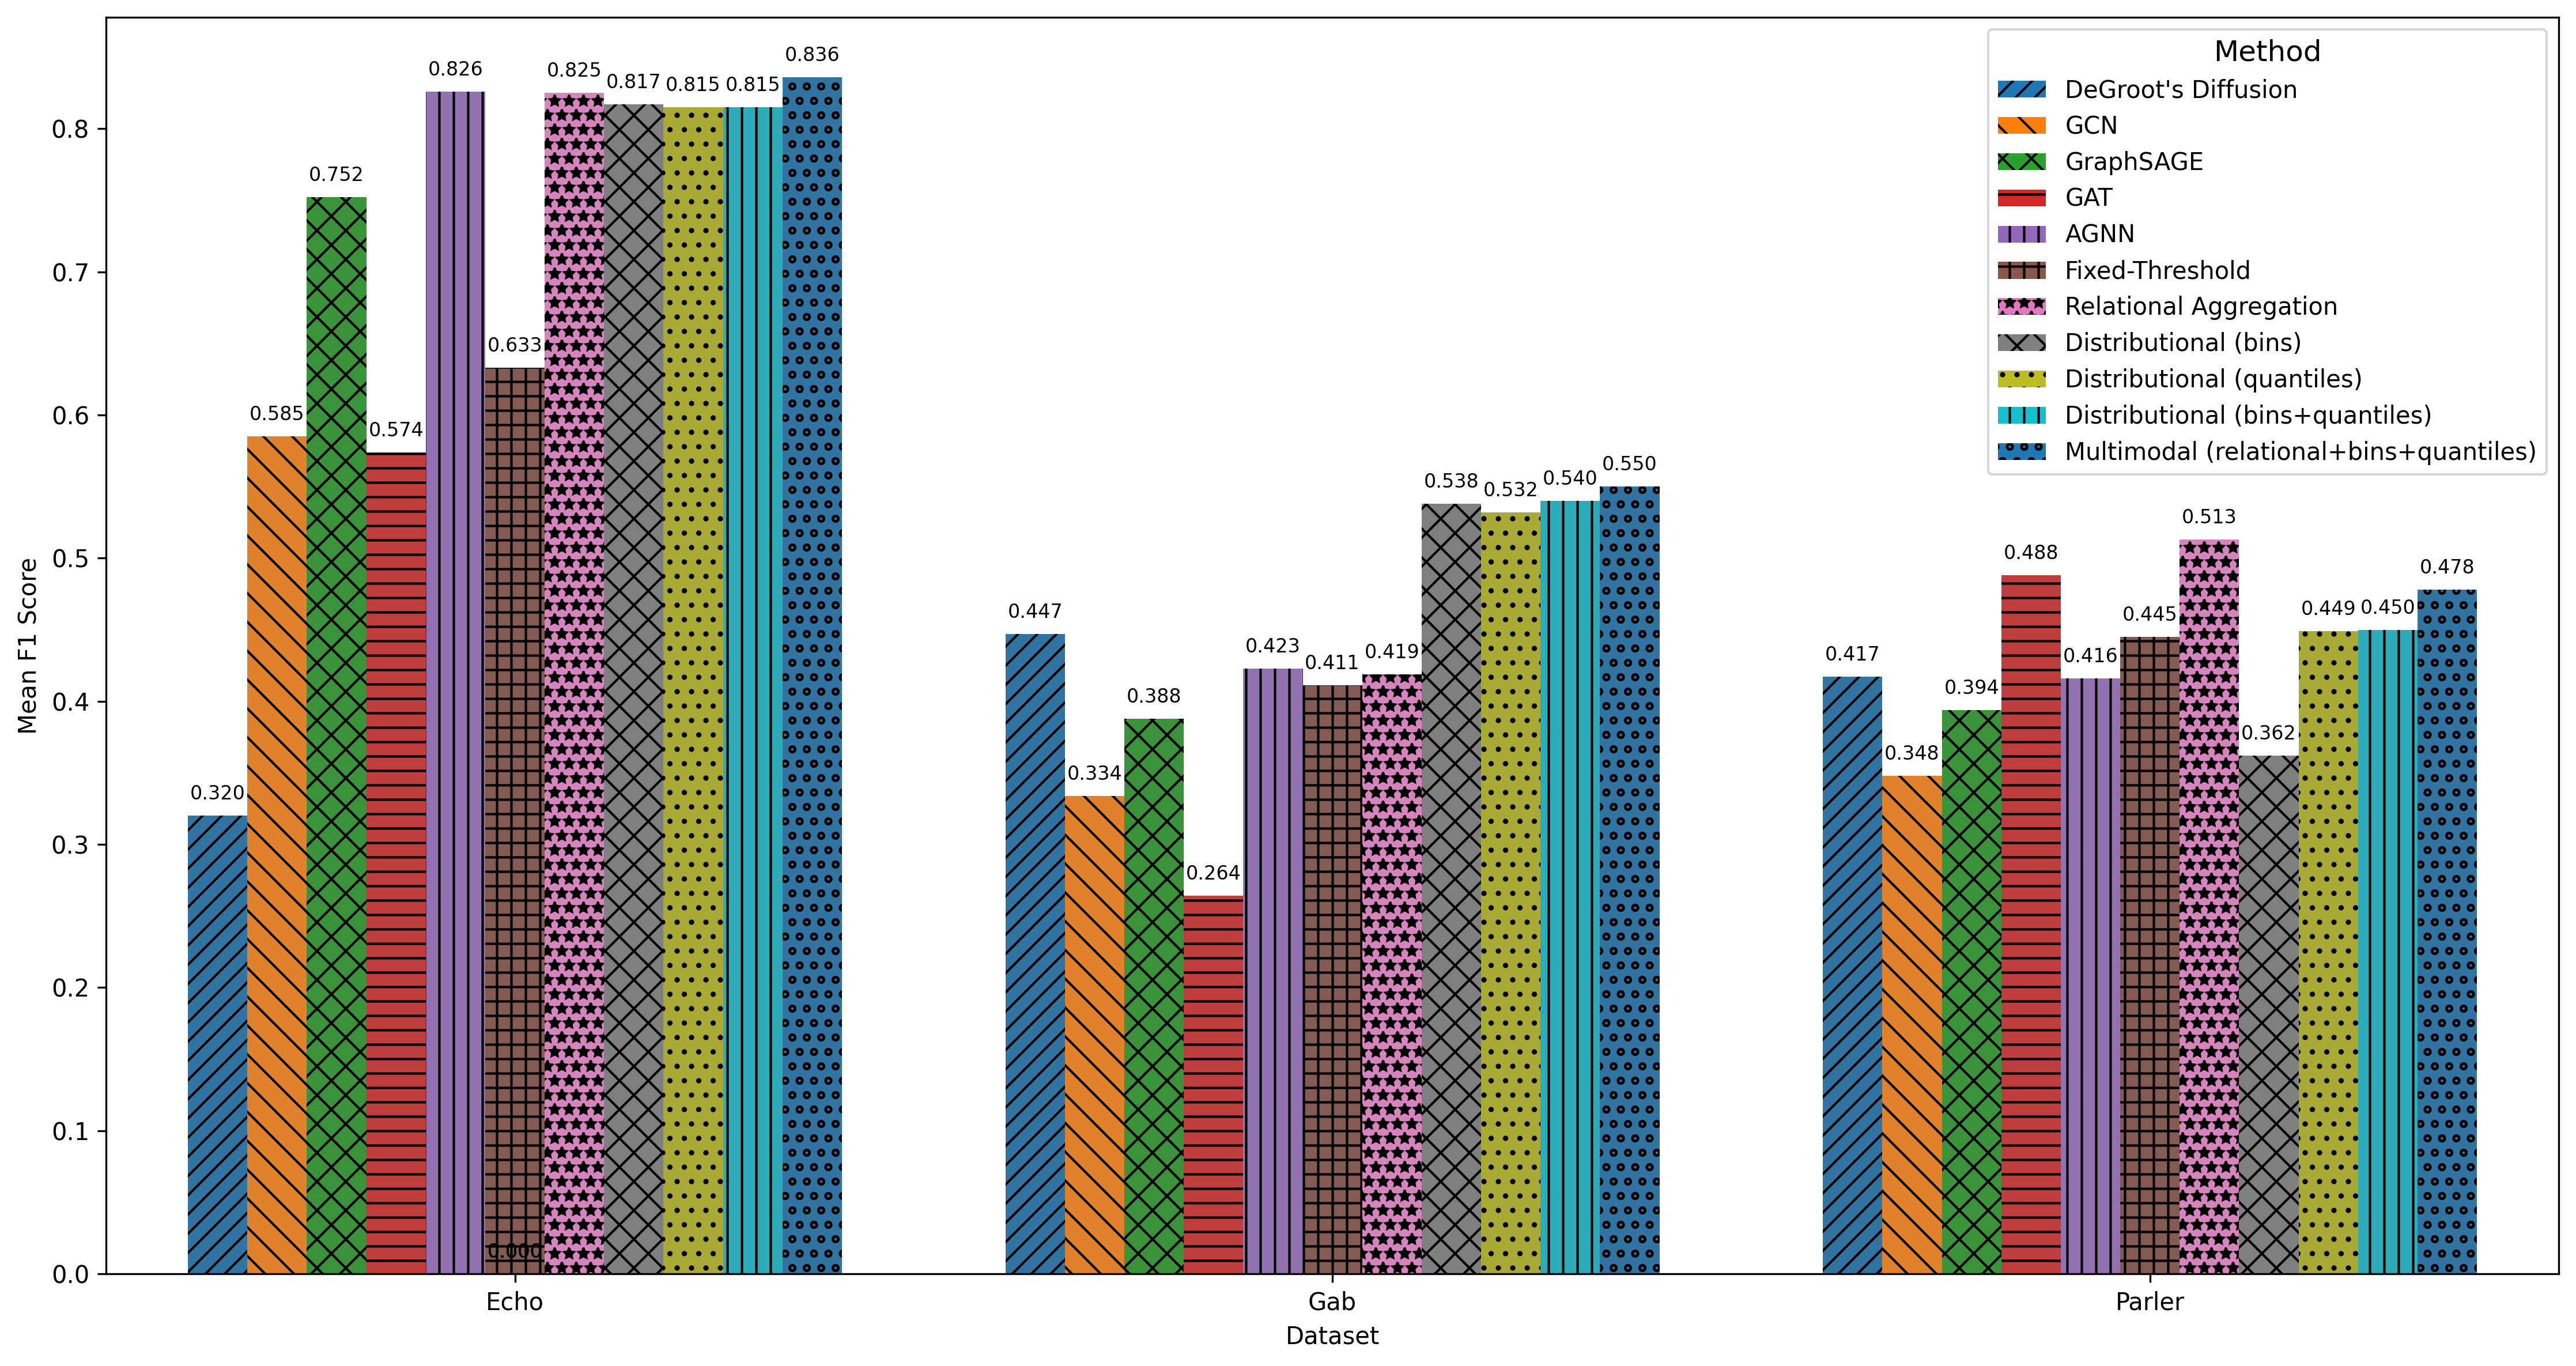

In [208]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load the data from the CSV file
df = pd.read_csv(os.path.join(aggregative_methods_dir, 'results.csv'))

# Extract the mean F1 scores from the 'F1' column
df['F1 Mean'] = df['F1'].apply(lambda x: float(x.split('±')[0]))

# Define more distinguishable patterns for each method
patterns = {
    "DeGroot's Diffusion": '///',
    'GCN': '\\\\',
    'GraphSAGE': 'xx',
    'GAT': '--',
    'AGNN': '||',
    'Fixed-Threshold': '++',
    'Relational Aggregation': '**',
    'Distributional (bins)': 'xx',
    'Distributional (quantiles)': '..',
    'Distributional (bins+quantiles)': '||',
    'Multimodal (relational+bins+quantiles)': 'oo'
}

# Define the color palette for methods using the 'deep' palette
palette = sns.color_palette('tab10', n_colors=len(df['Method'].unique()))
method_colors = {method: color for method, color in zip(df['Method'].unique(), palette)}

# Create the bar plot
plt.figure(figsize=(15, 8), dpi=300)
ax = sns.barplot(data=df, x='Dataset', y='F1 Mean', hue='Method', palette=method_colors, errorbar=None)

# Apply patterns to bars
for bars, method in zip(ax.containers, df['Method'].unique()):
    for bar in bars:
        bar.set_hatch(patterns[method])

# Add bar labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                fontsize=8,
                textcoords='offset points')

# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Mean F1 Score')
# plt.xticks(rotation=45)
plt.legend(title='Method')
plt.tight_layout()

# Create custom legend
handles = []

# Ensure legend order matches the order of methods in the data
for method in df['Method'].unique():
    handles.append(mpatches.Patch(facecolor=method_colors[method], hatch=patterns[method], label=method))

plt.legend(handles=handles, title='Method', fontsize=10, title_fontsize=12)

# Show the plot
plt.show()

# Node2Vec

In [18]:
import networkx as nx
from node2vec import Node2Vec

In [20]:
g.summary()

'IGRAPH DNW- 3746 20728 -- echo_2\n+ attr: name (g), doc2vec (v), label (v), name (v), predictions (v), weight (e)'

In [21]:
# Convert the igraph graph to a networkx graph
nx_g = nx.DiGraph()

# Add nodes with attributes (if any)
for v in g.vs:
    nx_g.add_node(v.index, **v.attributes())

# Add edges with attributes (if any)
for e in g.es:
    nx_g.add_edge(e.source, e.target, **e.attributes())

# Now nx_g is a networkx directed graph
print(nx_g.nodes(data=True))
print(nx_g.edges(data=True))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [22]:
nx_g.number_of_nodes(), nx_g.number_of_edges()

(3746, 20728)

In [23]:
graph = nx_g.copy()

In [25]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=5, num_walks=200, workers=32)  # Use temp_folder for big graphs

# Embed nodest
model = node2vec.fit(window=3, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

Generating walks (CPU: 32): 100%|██████████| 6/6 [00:00<00:00,  9.32it/s]
































KeyboardInterrupt



In [26]:
model

NameError: name 'model' is not defined

In [ ]:
# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

# iGraph and Torch Geometric

In [1]:
import igraph as ig
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
import numpy as np

/home/tommarz/.conda/envs/gnn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Convert igraph graph to edge index format for PyTorch Geometric
edge_index = torch.tensor(g.get_edgelist(), dtype=torch.long).t().contiguous()

# Extract edge weights and normalize them
edge_weights = np.array(g.es['weight'])
adj_matrix = np.zeros((g.vcount(), g.vcount()))

for edge, weight in zip(g.get_edgelist(), edge_weights):
    adj_matrix[edge[0], edge[1]] = weight

# Normalize the adjacency matrix to get transition probabilities
row_sums = adj_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
transition_probs = adj_matrix / row_sums

In [32]:
# Custom Node2Vec class
class CustomNode2Vec(Node2Vec):
    def __init__(self, edge_index, transition_probs, **kwargs):
        super().__init__(edge_index, **kwargs)
        self.transition_probs = torch.tensor(transition_probs, dtype=torch.float)

    def random_walk(self, start):
        walk = [start]

        while len(walk) < self.walk_length:
            cur = walk[-1]
            neighbors = self.adj[cur].nonzero(as_tuple=False).view(-1)
            if len(neighbors) == 0:
                break

            probs = self.transition_probs[cur, neighbors]
            probs = probs / probs.sum()  # Normalize to create a probability distribution
            next_node = neighbors[torch.multinomial(probs, 1).item()]
            walk.append(next_node.item())

        return walk

In [33]:
# Instantiate the custom Node2Vec model
model = CustomNode2Vec(edge_index, transition_probs, embedding_dim=128, walk_length=20, context_size=10, walks_per_node=10)

# Training the model
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}, Loss: {total_loss}')

Epoch 1, Loss: 185.1072187423706
Epoch 2, Loss: 140.63884973526
Epoch 3, Loss: 112.13075137138367
Epoch 4, Loss: 90.67388153076172
Epoch 5, Loss: 73.93935108184814
Epoch 6, Loss: 61.660982966423035
Epoch 7, Loss: 52.003345251083374
Epoch 8, Loss: 44.564350724220276
Epoch 9, Loss: 39.103289008140564
Epoch 10, Loss: 34.90759718418121
Epoch 11, Loss: 31.84196710586548
Epoch 12, Loss: 29.554018139839172
Epoch 13, Loss: 27.92202764749527
Epoch 14, Loss: 26.674623608589172
Epoch 15, Loss: 25.76576840877533
Epoch 16, Loss: 25.09849214553833
Epoch 17, Loss: 24.554694771766663
Epoch 18, Loss: 24.145031094551086
Epoch 19, Loss: 23.81687355041504
Epoch 20, Loss: 23.582777202129364
Epoch 21, Loss: 23.36396414041519
Epoch 22, Loss: 23.18405842781067
Epoch 23, Loss: 23.05288690328598
Epoch 24, Loss: 22.93579375743866
Epoch 25, Loss: 22.834594190120697
Epoch 26, Loss: 22.73940020799637
Epoch 27, Loss: 22.65616762638092
Epoch 28, Loss: 22.60861837863922
Epoch 29, Loss: 22.544051110744476
Epoch 30, Los

In [42]:
import torch
from torch_geometric.nn import Node2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [51]:
# Assuming the `model` has already been trained

# Extract embeddings from the Node2Vec model
model.eval()
embeddings = model().detach().numpy()

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings)

In [49]:
palette = {1: "red", 0: "blue", -1: "gray"}

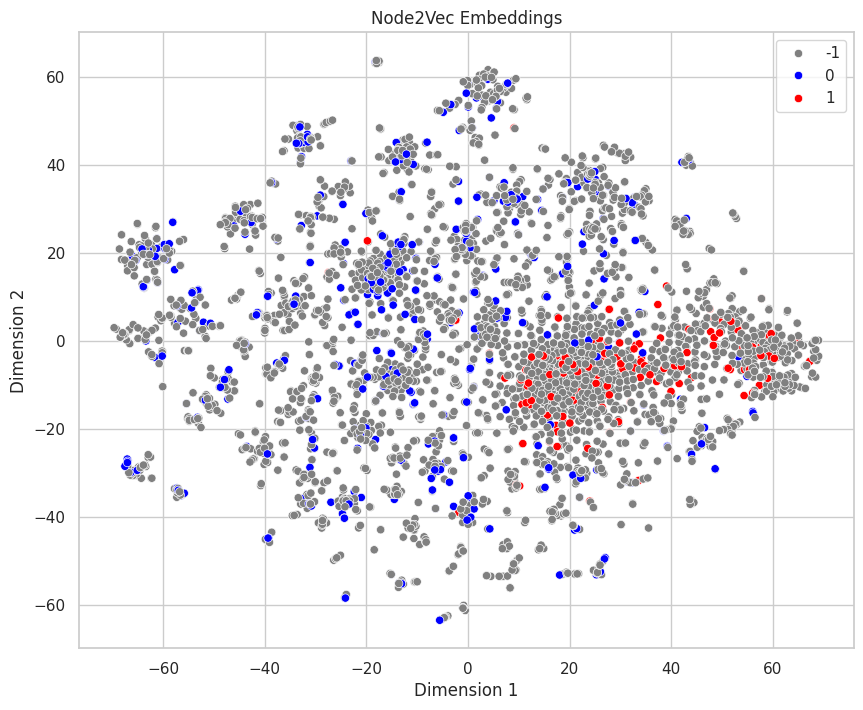

In [50]:
# Create a scatter plot using seaborn
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], palette=palette, hue=g.vs['label'])

plt.title("Node2Vec Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [57]:
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7f6e19b52440>, 0, {'name': '720749074190872578', 'label': -1, 'doc2vec': array([ 1.8017985 , -1.1926401 , -1.4771899 ,  0.10157511, -0.03804813,
       -1.2795528 ,  1.8373528 , -0.8191244 ,  1.0620683 , -2.4806998 ,
       -0.4784888 , -1.6380514 , -0.17522043, -0.5827199 ,  4.728616  ,
        0.37538463, -0.33898512, -0.76638097,  2.4999917 ,  2.003925  ,
        0.32299536, -0.2619776 ,  1.5539097 ,  3.9565115 , -0.5700062 ,
        1.3158993 , -2.5091586 ,  0.66848636, -4.556808  ,  1.2154177 ,
       -2.131256  , -1.8767437 ,  1.0800234 ,  2.5426464 , -1.0348394 ,
        0.20897436, -0.50102067, -1.6599933 , -0.03145847, -1.7069244 ,
       -1.4857163 , -0.9646176 , -0.49854144, -0.19974437, -2.7351859 ,
        0.46312064, -0.804099  ,  5.0890226 ,  0.3007311 , -3.4112103 ,
        0.13127069,  1.376384  , -1.0515527 ,  0.14419946, -0.65279484,
       -3.109371  , -1.2159    ,  1.964633  ,  1.8217081 , -2.2098625 ,
        1.7988108 ,  1.

In [63]:
labeled_nodes_embeddings = embeddings[labeled_nodes.indices]

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [67]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(labeled_nodes_embeddings, y.values, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [68]:
# Parameters
input_dim = embeddings.shape[1]  # Dimensionality of the embeddings
hidden_dim = 64
output_dim = 1  # Binary classification

# Initialize the model, loss function, and optimizer
model = MLPClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train.float())
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.6480
Epoch [20/100], Loss: 0.6090
Epoch [30/100], Loss: 0.5665
Epoch [40/100], Loss: 0.5189
Epoch [50/100], Loss: 0.4680
Epoch [60/100], Loss: 0.4170
Epoch [70/100], Loss: 0.3693
Epoch [80/100], Loss: 0.3270
Epoch [90/100], Loss: 0.2908
Epoch [100/100], Loss: 0.2604


In [71]:
# Evaluating the model
model.eval()
with torch.no_grad():
    outputs = model(X_test).squeeze()
    predicted = (outputs >= 0.5).long()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)
roc_auc = roc_auc_score(y_test, outputs)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Accuracy: 0.9159
Precision: 0.8788
Recall: 0.8529
F1 Score: 0.8657
ROC AUC: 0.9343
